In [1]:
import numpy as np
import numpy.linalg as LA
import meshplot as mp
from IPython.display import JSON as DJSON
from IPython.display import clear_output
from pspart import Part
from pspart import NNHash
import os
import pandas as ps
from mate_proposals import mate_proposals, homogenize_frame
from scipy.spatial.transform import Rotation as R
import onshape.brepio as brepio
import time
from automate.data.data import UniformMateData
import torch
import random
from automate.lightning_models.simplified import SimplifiedJointModel
from automate.data.transforms import compose
import meshplot as mp
from visualize import add_axis
from automate.data.transforms import select_full_relations
from torch_geometric.data import Batch

In [2]:
datapath = '/projects/grail/benjones/cadlab'

In [3]:
weights_path='/projects/grail/benjones/cadlab/dalton_lightning_logs/real_all_fn_args_amounts_sum_directedhybridgcn12/version_0/checkpoints/epoch=46-val_auc=0.666113.ckpt'
model = SimplifiedJointModel.load_from_checkpoint(weights_path, map_location=torch.device('cpu'))
transforms = model.transforms
del model

/fast/jamesn8/anaconda3/envs/torch3/lib/python3.9/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Metric` was deprecated since v1.3.0 in favor of `torchmetrics.metric.Metric`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [4]:
transform = compose(*(transforms[::-1]))

In [5]:
name = '/fast/jamesn8/assembly_data/assembly_data_with_transforms_all.h5'
assembly_df = ps.read_hdf(name,'assembly')
mate_df = ps.read_hdf(name,'mate')
part_df = ps.read_hdf(name,'part')
mate_df['MateIndex'] = mate_df.index
part_df['PartIndex'] = part_df.index

In [6]:
mate_df.set_index('Assembly', inplace=True)
part_df.set_index('Assembly', inplace=True)    

In [7]:
mate_types = [
            'PIN_SLOT',
            'BALL',
            'PARALLEL',
            'SLIDER',
            'REVOLUTE',
            'CYLINDRICAL',
            'PLANAR',
            'FASTENED'
        ]

In [8]:
def global_bounding_box(parts, transforms=None):
    if transforms is None:
        allpoints = [part.V for part in parts if part.V.shape[0] > 0]
    else:
        allpoints = [(tf[:3,:3] @ part.V.T + tf[:3,3,np.newaxis]).T for tf, part in zip(transforms, parts) if part.V.shape[0] > 0]
    if len(allpoints) == 0:
        return None
    minPt = np.array([points.min(axis=0) for points in allpoints]).min(axis=0)
    maxPt = np.array([points.max(axis=0) for points in allpoints]).max(axis=0)
    return np.vstack([minPt, maxPt])

In [9]:
def apply_transform(tf, v, is_points=True):
    "Apply the 4-matrix `tf` to a vector or column-wise matrix of vectors. If is_points, also add the translation."
    v_trans = tf[:3,:3] @ v
    if is_points:
        if v.ndim==1:
            v_trans += tf[:3,3]
        elif v.ndim==2:
            v_trans += tf[:3,3,np.newaxis]
    return v_trans

In [10]:
def cs_to_origin_frame(cs):
    origin = cs[:,3]
    if origin[3] != 1:
        origin /= origin[3]
    return origin[:3], cs[:3,:3]

In [11]:
def cs_from_origin_frame(origin, frame):
    cs = np.identity(4, np.float64)
    cs[:3,:3] = frame
    cs[:3,3] = origin
    return cs

In [12]:
out_base_path = '/fast/jamesn8/assembly_data/mate_torch_norm_match'

In [13]:
validate=True
prob_threshold = 0.7

if validate:
    weights_path_type = '/projects/grail/jamesn8/projects/mechanical/checkpoints/test-normonly-filtered-constant-centropy-weight-fulldata-type/geo_baseline/version_0/checkpoints/epoch=21-val_loss=1.444239.ckpt'
    weights_path_loc = '/projects/grail/jamesn8/projects/mechanical/checkpoints/test-normonly-filtered-constant-centropy-weight-fulldata/geo_baseline/version_0/checkpoints/epoch=14-val_loss=1.027152.ckpt'
    model_loc = SimplifiedJointModel.load_from_checkpoint(weights_path_loc, map_location=torch.device('cpu')).eval()
    model_type = SimplifiedJointModel.load_from_checkpoint(weights_path_type, map_location=torch.device('cpu')).eval()
    validation_indexfile = os.path.join(out_base_path, 'index_filtered2_val.txt')
    with open(validation_indexfile) as f:
        assembly_indices = list(set([int(l.split('-')[0]) for l in f.readlines()]))
else:
    with open('fully_connected_moving_no_multimates.txt','r') as f:
        assembly_indices = [int(l.rstrip()) for l in f.readlines()]

In [14]:
#start_index = 1243
start_index = 0

outpath = os.path.join(out_base_path, 'data')
statspath = os.path.join(out_base_path, 'stats')
logfile = os.path.join(statspath, 'log.txt')
def LOG(st):
    with open(logfile,'a') as logf:
        logf.write(st + '\n')
epsilon_rel = 0.001
max_groups = 10
max_mcs = 10000
max_mc_pairs = 100000
stride = 500
debug_run=False
save_stats=True
last_mate_ckpt = 0
last_ckpt = 0

all_stats = []
mate_stats = []
pair_stats = []
processed_indices = []
mate_indices = []
pair_indices = []
invalid_part_paths_and_transforms = []

run_start_time = time.time()
for num_processed,ind in enumerate(assembly_indices[start_index:]):
    stats = dict()
    curr_mate_stats = []
    #clear_output(wait=True)
    display(f'num_processed: {num_processed+start_index}/{len(assembly_indices[start_index:])}')

    #1. spatially hash all MCFs (cache hash maps for each part for re-use with individual mates)
    #2. for all mates, ensure that each MCF is represented (keep track of closest/equivalent MCFs, log percentage of assemblies for which this holds)
    #3. get proposals, edit appropriate ones to true based on equivalence class computed per mated pair of parts (taking outer product of equivalent MCs on left and right)

    print(assembly_df.loc[ind,"AssemblyPath"])
    LOG(f'{num_processed+start_index}/{len(assembly_indices[start_index:])}: processing {assembly_df.loc[ind,"AssemblyPath"]} at {time.time()-run_start_time}')
    
    part_subset = part_df.loc[ind]
    mate_subset = mate_df.loc[ind]
    if mate_subset.ndim == 1:
        mate_subset = ps.DataFrame([mate_subset], columns=mate_subset.keys())
    
    parts = []
    part_caches = []
    part_paths = []
    transforms = []
    #mcf_hashes = [] #hashes of normalized mcfs ([origin/maxdim, quat])
    mco_hashes = [] #hashes of origins only
    mcr_hashes = [] #hashes of origin+z direction (homogenized)
    mc_frames_all = [] #[[origin, homogenized rotmatrix]] for each mc for each part
    occ_to_index = dict()
    
    for j in range(part_subset.shape[0]):
        path = os.path.join(datapath, 'data/models', *[part_subset.iloc[j][k] for k in ['did','mv','eid','config']], f'{part_subset.iloc[j]["PartId"]}.xt')
        assert(os.path.isfile(path))
        with open(path) as partf:
            part_str = partf.read()
            part = Part(part_str)
            part_paths.append(path)
            part_caches.append(part_str)
            parts.append(part)
            tf = part_subset.iloc[j]['Transform']
            transforms.append(tf)
            occ_to_index[part_subset.iloc[j]['PartOccurrenceID']] = j
    
    
    bbox = global_bounding_box(parts, transforms)
    if bbox is None:
        LOG('skipping due to no geometry')
        continue
    minPt, maxPt = bbox
    
    median = bbox.mean(axis=0)
    dims = maxPt - minPt
    maxdim = max(dims)
    #maxdim = max([(part.bounding_box()[1]-part.bounding_box()[0]).max() for part in parts])
    
    p_normalized = np.identity(4, dtype=float)
    p_normalized[:3,3] = -median
    p_normalized[3,3] = maxdim #todo: figure out if this is double the factor

    norm_matrices = [p_normalized @ tf for tf in transforms]
    normalized_parts = [Part(cached_part, mat) for cached_part, mat in zip(part_caches, norm_matrices)]
    num_invalid_parts = 0
    for npart, path, mat in zip(normalized_parts, part_paths, norm_matrices):
        if not npart.valid:
            LOG(f'invalid part {path}')
            LOG(f'transform:\n{mat}')
            num_invalid_parts += 1
    stats['num_invalid_transformed_parts'] = num_invalid_parts
    stats['num_normalized_parts_with_different_graph_size'] = 0
    stats['num_normalized_parts_with_different_mcs'] = 0
    stats['num_normalized_parts_with_different_num_mcs'] = 0
    for npart, part in zip(normalized_parts, parts):
        if npart.num_topologies != part.num_topologies:
            stats['num_normalized_parts_with_different_graph_size'] += 1
        if len(npart.all_mate_connectors) != len(part.all_mate_connectors):
            stats['num_normalized_parts_with_different_num_mcs'] += 1
            stats['num_normalized_parts_with_different_mcs'] += 1
        else:
            mc_data = set()
            for mc in part.all_mate_connectors:
                mc_dat = (mc.orientation_inference.topology_ref, mc.location_inference.topology_ref, mc.location_inference.inference_type.value)
                mc_data.add(mc_dat)
            mc_data_normalized = set()
            for mc in npart.all_mate_connectors:
                mc_dat = (mc.orientation_inference.topology_ref, mc.location_inference.topology_ref, mc.location_inference.inference_type.value)
                mc_data_normalized.add(mc_dat)
            if mc_data != mc_data_normalized:
                stats['num_normalized_parts_with_different_mcs'] += 1
    
    del parts
    del transforms
    
    total_mcs = sum([len(part.all_mate_connectors) for part in normalized_parts])
    stats['total_mates'] = mate_subset.shape[0]
    stats['total_parts'] = len(normalized_parts)
    stats['maxdim'] = maxdim
    stats['total_mcs'] = total_mcs

    for j in range(len(normalized_parts)):
        part = normalized_parts[j]
        mc_frames = []
        #mc_frames_as_quat = []
        mc_origins = []
        for mc in part.all_mate_connectors:
            cs = mc.get_coordinate_system()
            origin, frame = cs_to_origin_frame(cs)
            frame_homogenized = homogenize_frame(frame, z_flip_only=True)
            #all_points.append(origin)
            #rot = R.from_matrix(frame_homogenized).as_quat()
            mc_origins.append(origin)
            mc_frames.append((origin, frame_homogenized))
            #mc_frames_as_quat.append(np.concatenate([origin, rot]))
        mc_ray = [np.concatenate([frame[0],frame[1][:,2]]) for frame in mc_frames]
        mc_frames_all.append(mc_frames)
        #frame_hash = NNHash(mc_frames_as_quat, 7, epsilon_rel)
        origin_hash = NNHash(mc_origins, 3, epsilon_rel)
        ray_hash = NNHash(mc_ray, 6, epsilon_rel)
        #mcf_hashes.append(frame_hash)
        mco_hashes.append(origin_hash)
        mcr_hashes.append(ray_hash)
        
    #debug
    #debug_origins = np.array(sum([[cs[0] for cs in mc_frames] for mc_frames in mc_frames_all], start=[]))
    #p = mp.plot(debug_origins, shading={'point_size': 0.05})
    #for part in normalized_parts:
    #    p.add_mesh(part.V, part.F)
    
    stats['invalid_frames'] = 0
    stats['invalid_mates'] = 0
    stats['invalid_coincident_origins'] = 0
    stats['invalid_permuted_z'] = 0
    
    mate_matches = [] #list of (left MC IDs, right MC Ids) based on the type of mate
    part_pair_to_mate = dict()

    #closest_invalid_dists = []
    #closest_invalid_dists_6dof = []

    mate_invalids = []
    for j in range(mate_subset.shape[0]):
        matches = [set(), set()]
        m_stats = dict()
        part_indices = []
        mate_invalid = False
        for i in range(2):
            occId = mate_subset.iloc[j][f'Part{i+1}']
            partIndex = occ_to_index[occId]
            part_indices.append(partIndex)
            assert(part_subset.iloc[partIndex]['PartOccurrenceID'] == occId)
            origin_local = mate_subset.iloc[j][f'Origin{i+1}']
            frame_local = mate_subset.iloc[j][f'Axes{i+1}']
            cs = cs_from_origin_frame(origin_local, frame_local)
            cs_transformed = norm_matrices[partIndex] @ cs
            origin, frame = cs_to_origin_frame(cs_transformed)
            frame_homogenized = homogenize_frame(frame, z_flip_only=True)
            #rot = R.from_matrix(frame_homogenized).as_quat()
            #mc_frame_normalized = np.concatenate([origin, rot])
            mate_ray = np.concatenate([origin, frame_homogenized[:,2]])
            neighbors = mcr_hashes[partIndex].get_nearest_points(mate_ray)

            for n in neighbors:
                matches[i].add(n)
            
            b_invalid = False
            b_num_matches = len(neighbors)
            b_invalid_coincident_origins = False
            b_invalid_permuted_z = False
            
            
            #compute statistics for the case where there are no matching mcs
            if len(neighbors) == 0:
                
                #debug: visualize mate frame
                #add_axis(p, origin, frame[:,0], frame[:,1], frame[:,2], scale=0.2)
                #mindist = np.inf
                #mindist_6dof = np.inf
                #closestId = -1
                #for l,origin2_frame2 in enumerate(mc_frames_all[partIndex]):
                #    origin2, frame2 = origin2_frame2
                #    dist = LA.norm(origin2 - origin)
                #    dist_6dof = LA.norm(np.concatenate([origin2, R.from_matrix(frame2).as_quat()]) - np.concatenate([origin, R.from_matrix(frame_homogenized).as_quat()]))
                #    if dist < mindist:
                #        mindist = dist
                #        mindist_6dof = dist_6dof
                #        closestId = l
                #closest_invalid_dists.append(mindist)
                #closest_invalid_dists_6dof.append(mindist_6dof)
                #closestorigin = mc_frames_all[partIndex][closestId][0]
                #closestframe = mc_frames_all[partIndex][closestId][1]
                #add_axis(p,closestorigin, closestframe[:,0],closestframe[:,1],closestframe[:,2], scale=0.2)
                
                b_invalid = True
                stats['invalid_frames'] += 1
                if not mate_invalid:
                    stats['invalid_mates'] += 1
                    mate_invalid = True
                
                origin_neighbors = mco_hashes[partIndex].get_nearest_points(origin)
                if len(origin_neighbors) > 0:
                    b_invalid_coincident_origins = True
                    stats['invalid_coincident_origins'] += 1
                    n = next(iter(origin_neighbors))
                    
                    #detect whether allowing Z permutations would make this frame match
                    c_frame = mc_frames_all[partIndex][n][1]
                    c_frame_homogenized = homogenize_frame(c_frame, z_flip_only=False)
                    mate_frame_homogenized = homogenize_frame(frame, z_flip_only=False)
                    dist = LA.norm(c_frame_homogenized - mate_frame_homogenized)

                    if dist < epsilon_rel:
                        b_invalid_permuted_z = True
                        stats['invalid_permuted_z'] += 1
            else:
                mateType = mate_subset.iloc[j]['Type']
                mc_frames = mc_frames_all[partIndex]
                for k,c_origin_frame in enumerate(mc_frames):
                    c_origin, c_frame = c_origin_frame
                    axisdist = LA.norm(c_frame[:,2] - frame_homogenized[:,2])
                    if axisdist < epsilon_rel:
                        projdist = np.inf
                        if mateType == 'CYLINDRICAL' or mateType == 'SLIDER':
                            c_origin_proj = c_origin @ frame_homogenized[:,:2]
                            origin_proj = origin @ frame_homogenized[:,:2]
                            projdist = LA.norm(c_origin_proj - origin_proj)
                        elif mateType == 'PLANAR' or mateType == 'PARALLEL':
                            c_origin_proj = c_origin.dot(frame_homogenized[:,2])
                            origin_proj = origin.dot(frame_homogenized[:,2])
                            projdist = abs(c_origin_proj - origin_proj)
                        if projdist < epsilon_rel:
                            matches[i].add(k)
                    
            
            m_stats[f'invalid_frame_{i}'] = b_invalid
            m_stats[f'invalid_frame_{i}_coincident_origins'] = b_invalid_coincident_origins
            m_stats[f'invalid_frame_{i}_permuted_z'] = b_invalid_permuted_z
            m_stats[f'matches_frame_{i}'] = b_num_matches
            m_stats[f'extra_matches_frame_{i}'] = len(matches[i]) - b_num_matches
        m_stats['type'] = mate_subset.iloc[j]['Type']
        m_stats['truncated_mc_pairs'] = False
        curr_mate_stats.append(m_stats)
        mate_indices.append(mate_subset.iloc[j]['MateIndex'])
        mate_invalids.append(mate_invalid)
        mate_matches.append(matches)
        part_indices = tuple(sorted(part_indices))
        part_pair_to_mate[part_indices] = j#mate_subset.iloc[j]['Type']
    
    if total_mcs <= max_mcs and stats['num_normalized_parts_with_different_graph_size'] == 0:
        stats['false_part_pairs'] = 0
        stats['missed_part_pairs'] = 0
        stats['missed_mc_pairs'] = 0
        
        #find match proposals
        start = time.time()
        dummytransforms = [np.identity(4) for l in range(len(normalized_parts))]
        proposals = mate_proposals(list(zip(dummytransforms, normalized_parts)), epsilon_rel=epsilon_rel, max_groups=max_groups)
        end = time.time()
        stats['num_proposals'] = len(proposals)
        stats['proposal_time'] = end-start
        
        #initialize pairs based on proposals
        part_proposals = dict()
        for proposal in proposals:
            part_pair = proposal[:2]
            if part_pair not in part_proposals:
                mc_pair_dict = dict()
                part_proposals[part_pair] = mc_pair_dict
            else:
                mc_pair_dict = part_proposals[part_pair]
            mc_pair_dict[proposal[2:]] = -1 #mate type

        #populate pairs with labels
        #print('populating pairs with labels')
        part_pair_found=False
        mc_pair_found=False
        for j in range(mate_subset.shape[0]):
            if not mate_invalids[j]:
                mate_type = mate_subset.iloc[j]['Type']
                partIds = [occ_to_index[mate_subset.iloc[j][f'Part{i+1}']] for i in range(2)]
                matches = mate_matches[j]

                if partIds[0] > partIds[1]:
                    partIds.reverse()
                    matches = matches.copy()
                    matches.reverse()
                partIds = tuple(partIds)

                if partIds in part_proposals:
                    part_pair_found=True
                    mc_pair_dict = part_proposals[partIds]
                    for index1 in matches[0]:
                        for index2 in matches[1]:
                            mc_pair = index1, index2
                            if mc_pair in mc_pair_dict:
                                mc_pair_found=True
                                mc_pair_dict[mc_pair] = mate_types.index(mate_type)
            if not part_pair_found:
                stats['missed_part_pairs'] += 1
            if not mc_pair_found:
                stats['missed_mc_pairs'] += 1
            curr_mate_stats[j]['part_pair_found'] =  part_pair_found           
            curr_mate_stats[j]['mc_pair_found'] =  mc_pair_found     
        
        #create data object for each part pair
        #print('creating data object')
        part_pair_predictions = dict()
        for part_pair in part_proposals:
            pair_stat = dict()
            pair_stat['Assembly'] = ind
            pair_stat['MateIndex'] = -1
            pair_stat['MateType'] = ''
            if normalized_parts[part_pair[0]].valid and normalized_parts[part_pair[1]].valid:
                mateIndex = -1
                if part_pair in part_pair_to_mate:
                    mateIndex = part_pair_to_mate[part_pair]
                    mateType = mate_subset.iloc[mateIndex]['Type']
                    pair_stat['MateIndex'] = mateIndex
                    pair_stat['MateType'] = mateType
                else:
                    mateType='FASTENED'
                    stats['false_part_pairs'] += 1
                mc_pairs = part_proposals[part_pair]
                
                if len(mc_pairs) > max_mc_pairs:
                    curr_mate_stats[mateIndex]['truncated_mc_pairs'] = True
                    mc_pairs_final=[]
                    mc_pairs_false=[]
                    for pair in mc_pairs:
                        if mc_pairs[pair] >= 0:
                            mc_pairs_final.append(pair)
                        else:
                            mc_pairs_false.append(pair)
                    N_true = len(mc_pairs_final)
                    N_remainder = max_mc_pairs - N_true
                    random.shuffle(mc_pairs_false)
                    for pair in mc_pairs_false[:N_remainder]:
                        mc_pairs_final.append(pair)
                else:
                    mc_pairs_final = list(mc_pairs.keys())

                part1 = normalized_parts[part_pair[0]]
                part2 = normalized_parts[part_pair[1]]
                or1, loc1, inf1 = part1.get_onshape_def_from_mc(part1.all_mate_connectors[0])
                or2, loc2, inf2 = part2.get_onshape_def_from_mc(part2.all_mate_connectors[0])

                data = UniformMateData(
                    normalized_parts[part_pair[0]],
                    or1,
                    loc1,
                    inf1,
                    norm_matrices[part_pair[0]],
                    normalized_parts[part_pair[1]],
                    or2,
                    loc2,
                    inf2,
                    norm_matrices[part_pair[1]],
                    mateType
                )
                data = transform(data)
                data.mc_pairs = torch.empty((6, len(mc_pairs_final)), dtype=torch.int64)
                data.mc_pair_labels = torch.zeros(len(mc_pairs_final), dtype=torch.float32)
                all_mcs = [normalized_parts[partIndex].all_mate_connectors for partIndex in part_pair]
                for k,pair in enumerate(mc_pairs_final):
                    type_index = mc_pairs[pair]
                    if type_index >= 0:
                        data.mc_pair_labels[k] = 1
                    mcs = [mc_list[mcIndex] for mc_list, mcIndex in zip(all_mcs, pair)]
                    col = torch.tensor([mcs[0].orientation_inference.topology_ref, mcs[0].location_inference.topology_ref, mcs[0].location_inference.inference_type.value,
                          mcs[1].orientation_inference.topology_ref, mcs[1].location_inference.topology_ref, mcs[1].location_inference.inference_type.value], dtype=torch.int)
                    data.mc_pairs[:,k] = col
                #dataname = f'{assembly_df.loc[ind,"AssemblyPath"]}-{part_subset.iloc[part_pair[0]]["PartOccurrenceID"].replace("/","_")}-{part_subset.iloc[part_pair[1]]["PartOccurrenceID"].replace("/","_")}.dat'
                assert(data.node_types_g1.shape[0] == part1.num_topologies)
                assert(data.node_types_g2.shape[0] == part2.num_topologies)
                assert(data.mc_pairs[0].max().item() < part1.num_topologies)
                assert(data.mc_pairs[1].max().item() < part1.num_topologies)
                assert(data.mc_pairs[3].max().item() < part2.num_topologies)
                assert(data.mc_pairs[4].max().item() < part2.num_topologies)
                if not debug_run and not validate:
                    dataname = f'{ind}-{part_subset.iloc[part_pair[0]]["PartIndex"]}-{part_subset.iloc[part_pair[1]]["PartIndex"]}.dat'
                    torch_datapath = os.path.join(outpath, dataname)
                    count = 0
                    while os.path.isfile(torch_datapath):
                        count += 1
                        torch_datapath_new = os.path.splitext(torch_datapath)[0] + f'-{count}.dat'
                        torch_datapath = torch_datapath_new
                    torch.save(data, torch_datapath)
                    del data
                if validate:
                    mateDetected = ''
                    locationCorrect = False
                    #axisCorrect = False
                    data = select_full_relations(data)
                    follow_batch=[
                        'node_types_g1', 'node_types_g2',
                        'mc_index_g1', 'mc_index_g2',
                        'mc_pair_labels',
                        'left_mc_individual_labels', 'right_mc_individual_labels'
                    ]
                    batch = Batch.from_data_list([data], follow_batch=follow_batch)
                    preds_location = torch.sigmoid(model_loc(batch))
                    
                    if part_pair in part_pair_to_mate:
                        maxCorrectProb = 0
                        for k,pair in enumerate(mc_pairs_final):
                            if mc_pairs[pair] >= 0:
                                maxCorrectProb = max(maxCorrectProb, preds_location[k].item())
                        pair_stat['MaxInferredProbOfRealMate'] = maxCorrectProb
                    
                    best_ind = torch.argmax(preds_location).item()
                    if preds_location[best_ind].item() > prob_threshold:
                        best_pair = mc_pairs_final[best_ind]
                        locationCorrect = mc_pairs[best_pair] >= 0
                        batch.mc_pair_labels = torch.zeros_like(batch.mc_pair_labels)
                        batch.mc_pair_labels[best_ind] = 1
                        preds_type = torch.sigmoid(model_type(batch))
                        best_type = preds_type[0,:].argmax()
                        mateDetected = mate_types[best_type]
                    pair_stat['InferredMateType'] = mateDetected
                    pair_stat['LocationCorrect'] = locationCorrect
            pair_stats.append(pair_stat)
            pair_indices.append((part_subset.iloc[part_pair[0]]['PartIndex'],part_subset.iloc[part_pair[1]]['PartIndex']))
            
    for stat in curr_mate_stats:
        mate_stats.append(stat)
    all_stats.append(stats)
    processed_indices.append(ind)
    
    if not validate and save_stats and (num_processed+1) % stride == 0:
        
        stat_df_mini = ps.DataFrame(all_stats[last_ckpt:], index=processed_indices[last_ckpt:])
        mate_stat_df_mini = ps.DataFrame(mate_stats[last_mate_ckpt:], index=mate_indices[last_mate_ckpt:])
        stat_df_mini.to_parquet(os.path.join(statspath, f'stats_{num_processed + start_index}.parquet'))
        mate_stat_df_mini.to_parquet(os.path.join(statspath, f'mate_stats_{ind}.parquet'))
        last_mate_ckpt = len(mate_indices)
        last_ckpt = len(processed_indices)

'num_processed: 0/3400'

6954857d4afa7a3408fbeb4b_6a322e29959228eeca4b8566_08905514649024ff45049db8


'num_processed: 1/3400'

29c920c9c8649566d09b8a29_8ca560b6f13616852f03ff64_dba93c3d4064b2ca5e86f367


'num_processed: 2/3400'

57fbae4ab54dff10aa62f1cf_55a91f2bf9a26bb4ed162787_0676593a1ffcea55b4d7b02d


'num_processed: 3/3400'

5818d6c4ca58d81087615c2b_ecf901413c23095f0a4f4685_97f0c51b9a6e61844067b7f7


'num_processed: 4/3400'

4c2e30e03b6debea0a7d8a0d_82140d6690a9bfc6fe85c030_749e40740918ae4b47fee457


'num_processed: 5/3400'

58db32813d69580f7f18db7c_b71ab89867a6a28fbbd796af_60af0f9cc91dfe4a8e0c5db8


'num_processed: 6/3400'

1b13d4fb53b5d579823aeb3a_3bffbabdfe2467398a4ab1d6_cb5ddb4015c022ab66828449


'num_processed: 7/3400'

a94c5c14d76379669e3bf987_583e591e4642827923e32cfc_2ee4a7fc3d149d655771360e


'num_processed: 8/3400'

58de0d9e25c753102f640805_0499be6c85a9479172a459ed_4e46ea3fbe4c8eb57a59e513


'num_processed: 9/3400'

a9d3f0a224f923e28595f5f1_9c753fec71ccc566a6e9faa4_6eb02270dd694ac8e4028120


'num_processed: 10/3400'

25810b6ce462551758ee0299_66b253044fc0ad1377599441_fc7a6c0208e0edc1aa0283b8


'num_processed: 11/3400'

f1a6dab4e06dc624780f12e7_05da82603d03e5a26540a0f4_3436323e6eb0d138e7a7f9f9


'num_processed: 12/3400'

749e9f9eb3aaf936168a6fc9_c9b9a5cb6ff927d944d858bf_7633d5dabe52b413e419a3ce


'num_processed: 13/3400'

afc8aa9a274eee2c299c884c_02b51422206e52a5d55cc9ca_333870f133abbe7772620b6d


'num_processed: 14/3400'

6ddbdbb30590a035d056446e_805d1b874b42451fcc5ab72a_932983ad23711dd12244ab65


'num_processed: 15/3400'

53f702e50af776ed39f82ef2_6cecbae7b717001ba8eaf73c_abac228e1690d25dbc4e612f


'num_processed: 16/3400'

28c8b7988af3726dcda7c0e9_9f81fd395ec45538cfd2795c_ce6bb2d702214089ead65ec6


'num_processed: 17/3400'

a20ab0a24e8cf5d0bc297067_6ba8e14bc911cb9d7d4a658c_3499a73050a4e4d52cedfd15


'num_processed: 18/3400'

bd0439e45e5313707b9781d0_a3eca6e657a3c335de636a42_848574c8c8628536bc3dce21


'num_processed: 19/3400'

9dd23dcea4691090d6a8d8cf_651044e4f3814c88867c134d_972a8e9ec7566ca5196d5138


'num_processed: 20/3400'

709a85d928053ff819b6a1ff_3b2a5b70b044580e4ff407e1_4c818d1401959afc46278697


'num_processed: 21/3400'

67095a0eeb30f6925b4d4f27_4cbb9891cde8ace5ae0ef772_791939ad437098a4fa734037


'num_processed: 22/3400'

f6a47d27b2e343ca0732cc4f_9356269c2542ae0b62850806_71f8c76df2faf44f1be6af1a


'num_processed: 23/3400'

1b480902d552df9d59285bbe_8e123cffc24a35dfb0cfcece_9f00424a0b3684d091556080


'num_processed: 24/3400'

a875ecc7b04316eac6ff74b6_877d6b967d7ab32be90f1272_9d1d26521c327195952a089d


'num_processed: 25/3400'

04d63eb9d9311dcd8623142b_ca03af72e368ded83848f64e_0a684af8f9f09eef94b0f5c2


'num_processed: 26/3400'

402fe03c06916760da785068_9feb7538f0cc8162e3c88485_c8165edf79d8ae7e6d7ce319


KeyboardInterrupt: 

In [36]:
#pair_stats_df = ps.DataFrame(pair_stats, index=pair_indices)
pair_stats_df = ps.read_parquet(os.path.join(statspath, 'pair_stats_validate.parquet'))

In [26]:
pair_stats_df.keys()

Index(['Assembly', 'MateIndex', 'MateType', 'MaxInferredProbOfRealMate',
       'InferredMateType', 'LocationCorrect'],
      dtype='object')

In [32]:
realmatepairs = pair_stats_df[lambda df: df['MateType'] != '']
matched_pairs_anymate = realmatepairs[lambda df: df['InferredMateType'] != '']
precision_anymate = matched_pairs_anymate.shape[0] / realmatepairs.shape[0]
precision_correct_type = (realmatepairs['InferredMateType'] == realmatepairs['MateType']).sum()/realmatepairs.shape[0]
inferredmatepairs = pair_stats_df[lambda df: df['InferredMateType'] != '']
recall_anymate = (inferredmatepairs['MateType'] != '').sum()/inferredmatepairs.shape[0]
recall_correct_type = (inferredmatepairs['MateType'] == inferredmatepairs['InferredMateType']).sum()/inferredmatepairs.shape[0]
correct_location = matched_pairs_anymate['LocationCorrect'].sum()/matched_pairs_anymate.shape[0]
missed_mates = realmatepairs[lambda df: df['InferredMateType'] == '']


<AxesSubplot:>

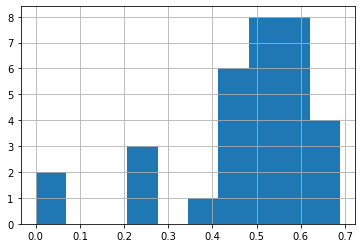

In [31]:
missed_mates['MaxInferredProbOfRealMate'].hist()

In [21]:
precision_anymate

0.7064220183486238

In [23]:
precision_correct_type

0.28440366972477066

In [25]:
recall_anymate

0.3737864077669903

In [33]:
recall_correct_type

0.15048543689320387

In [28]:
correct_location

0.18181818181818182

In [20]:
stats_df = ps.DataFrame(all_stats, index=processed_indices)
mate_stats_df = ps.DataFrame(mate_stats, index=mate_indices)

In [22]:
stats_df.to_parquet(os.path.join(statspath, 'stats_all.parquet'))
mate_stats_df.to_parquet(os.path.join(statspath, 'mate_stats_all.parquet'))

In [37]:
stats_df

,num_invalid_transformed_parts,num_normalized_parts_with_different_graph_size,num_normalized_parts_with_different_mcs,num_normalized_parts_with_different_num_mcs,total_mates,total_parts,maxdim,total_mcs,invalid_frames,invalid_mates,invalid_coincident_origins,invalid_permuted_z,false_part_pairs,missed_part_pairs,missed_mc_pairs,num_proposals,proposal_time
18,0,0,1,1,17,18,0.274000,22844,12,9,2,0,NaN,NaN,NaN,NaN,NaN
19,0,0,0,0,2,3,2.159000,686,4,2,4,1,1.0,2.0,2.0,9977.0,0.182131
22,2,0,0,0,21,22,0.200000,4972,10,8,9,2,65.0,0.0,0.0,53100.0,1.426332
23,0,0,0,0,2,3,0.414338,2536,1,1,1,0,1.0,1.0,1.0,28411.0,1.572925
26,0,0,0,0,15,16,0.061500,4960,16,10,9,0,97.0,0.0,0.0,291488.0,3.869053
38,0,0,1,1,6,7,0.295275,9357,1,1,1,0,6.0,0.0,0.0,156450.0,6.770895
40,0,0,0,0,1,2,0.022928,255,2,1,2,0,0.0,1.0,1.0,12.0,0.114647
45,0,0,0,0,3,4,0.182701,129,0,0,0,0,3.0,0.0,0.0,2284.0,0.046940
53,0,0,0,0,4,5,0.191500,4395,2,2,0,0,6.0,1.0,1.0,14836.0,1.519457
64,0,0,0,0,42,43,0.127000,7987,11,11,11,0,324.0,0.0,0.0,529541.0,11.483893


In [ ]:
num_processed

In [24]:
data

UniformMateData(amounts_data_g1=[167, 1], amounts_data_g2=[252, 1], brep_directed_edge_index_g1=[2, 284], brep_directed_edge_index_g2=[2, 450], brep_edge_types_g1=[284], brep_edge_types_g2=[450], brep_edges_g1=[2, 284], brep_edges_g2=[2, 450], face_edge_edge_index_g1=[2, 128], face_edge_edge_index_g2=[2, 200], face_edge_edge_map_g1=[64, 1], face_edge_edge_map_g2=[100, 1], face_edge_edge_types_g1=[64], face_edge_edge_types_g2=[100], face_edge_edges_g1=[2, 64], face_edge_edges_g2=[2, 100], face_edge_topology_map_g1=[2, 284], face_edge_topology_map_g2=[2, 450], left_mc_individual_labels=[18], left_mc_individual_refs=[4, 18], mate_type=[1], mc_pair_labels=[8179], mc_pair_type=[162], mc_pairs=[6, 8179], mc_pairs_left_cs=[162, 16], mc_pairs_right_cs=[162, 16], node_types_g1=[167], node_types_g2=[252], num_G_edges_g1=64, num_G_edges_g2=100, num_G_faces_g1=31, num_G_faces_g2=46, num_G_loops_g1=36, num_G_loops_g2=50, num_G_verts_g1=36, num_G_verts_g2=56, p_normalized_g1=[4, 4], p_normalized_g2=

In [26]:
data.node_types_g2.shape

torch.Size([252])

In [27]:
part2

<Part with 280 nodes and 502 links>

In [28]:
normalized_parts[part_pair[1]]

<Part with 252 nodes and 450 links>